This notebook is on Google Colab

https://colab.research.google.com/drive/1fV1Bis-qis3bAOlkBJfD_026JErMvnm3?usp=sharing

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Inception_v3

*Author: Pytorch Team*

**Also called GoogleNetv3, a famous ConvNet trained on Imagenet from 2015**

<img src="https://pytorch.org/assets/images/inception_v3.png" alt="alt" width="50%"/>

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `299`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [4]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

In [6]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-03-22 13:49:26--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-03-22 13:49:26 (80.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



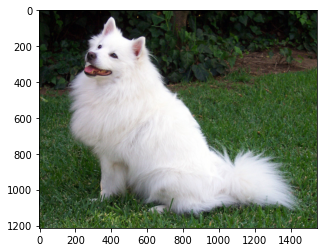

In [7]:
import matplotlib.pyplot as plt 
plt.imshow(input_image)

In [8]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8238473534584045
Arctic fox 0.014191625639796257
white wolf 0.012303533963859081
Pomeranian 0.007874682545661926
keeshond 0.006387812085449696


### Model Description

Inception v3: Based on the exploration of ways to scale up networks in ways that aim at utilizing the added computation as efficiently as possible by suitably factorized convolutions and aggressive regularization. We benchmark our methods on the ILSVRC 2012 classification challenge validation set demonstrate substantial gains over the state of the art: 21.2% top-1 and 5.6% top-5 error for single frame evaluation using a network with a computational cost of 5 billion multiply-adds per inference and with using less than 25 million parameters. With an ensemble of 4 models and multi-crop evaluation, we report 3.5% top-5 error on the validation set (3.6% error on the test set) and 17.3% top-1 error on the validation set.

The 1-crop error rates on the imagenet dataset with the pretrained model are listed below.

| Model structure | Top-1 error | Top-5 error |
| --------------- | ----------- | ----------- |
|  inception_v3        | 22.55       | 6.44        |

### References

 - [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567).

# Saliency maps
CAM / Tutorial using the basic resnet18 model

package 
https://github.com/frgfm/torch-cam

the tutorial [here](https://colab.research.google.com/github/frgfm/notebooks/blob/main/torch-cam/quicktour.ipynb#scrollTo=BKIiNXKWd8f7)

<font color=red>Warning!</font> we are using a model trained on the ImageNet data set

While you can read on the CUB webpage that you should take care to use models pretrained on ImageNet as there may be overlap with the CUB test set, your main point here is not to assess performance, but to investigate explanations. So if you do want to use pretrained models, just make sure to
mention the risk of overestimating performance in your poster


Here we are using Class activation mappings. In particular SmoothGradCAMpp(++) which is a combination of the methods from two other recent techniques — SMOOTHGRAD and Grad-CAM++. Grad-CAM++ is itself an improvement on the vanilla Grad-CAM.

In [59]:
pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM
# https://frgfm.github.io/torch-cam/methods.html#torchcam.methods.SmoothGradCAMpp
# I believe this is smoothgrad from the lecture
from PIL import Image
from torchvision import transforms
import glob

In [145]:
# set up model, pretrained on imagenet
model = resnet18(weights='DEFAULT').eval()

# Set your CAM extractor
cam_extractor = SmoothGradCAMpp(model,target_layer='layer4') # layer 4 is the last conv layer of the model
# Get your input
img2 = read_image("/Northern_Fulmar_0090_43867.jpg")
img = read_image("/Pigeon_Guillemot_0109_39872.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

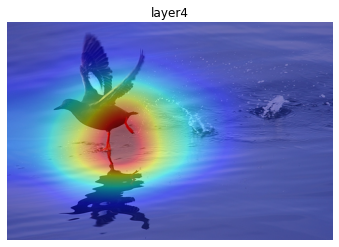

In [63]:
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [153]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()
# If you get the error
# RuntimeError: cannot register a hook on a tensor that doesn't require gradient
# run this cell

Inception V3 model. This is the same as the one from the concept bottleneck
[Tutorial](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_inception_v3.ipynb#scrollTo=toxic-harassment)

In [154]:
# set up model, pretrained on imagenet
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights='DEFAULT')
model.eval()

input_image = Image.open("/Pigeon_Guillemot_0109_39872.jpg")
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# I do not believe that the CAM package works with cuda
# move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


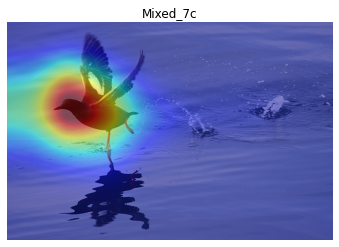

In [155]:
# Set your CAM extractor
# just use the default last layer, otherwise specify target_layer='some layer' 
# to see all the layers just write 'model' in a new cell and you'll see them.
cam_extractor = SmoothGradCAMpp(model)
# Normally you would use "with torch.no_grad():" in the forward pass of the model. But not here
# if you use with torch.no_grad(): the model stops tracking the gradients, which we need to calculate the saliency map
out = model(input_batch)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()
cam_extractor.remove_hooks()

## Run through all test images

In [77]:
imgs = glob.glob('handful_of_images/*.jpg')
len(imgs)

10

In [107]:
preprocess_visualise = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
])

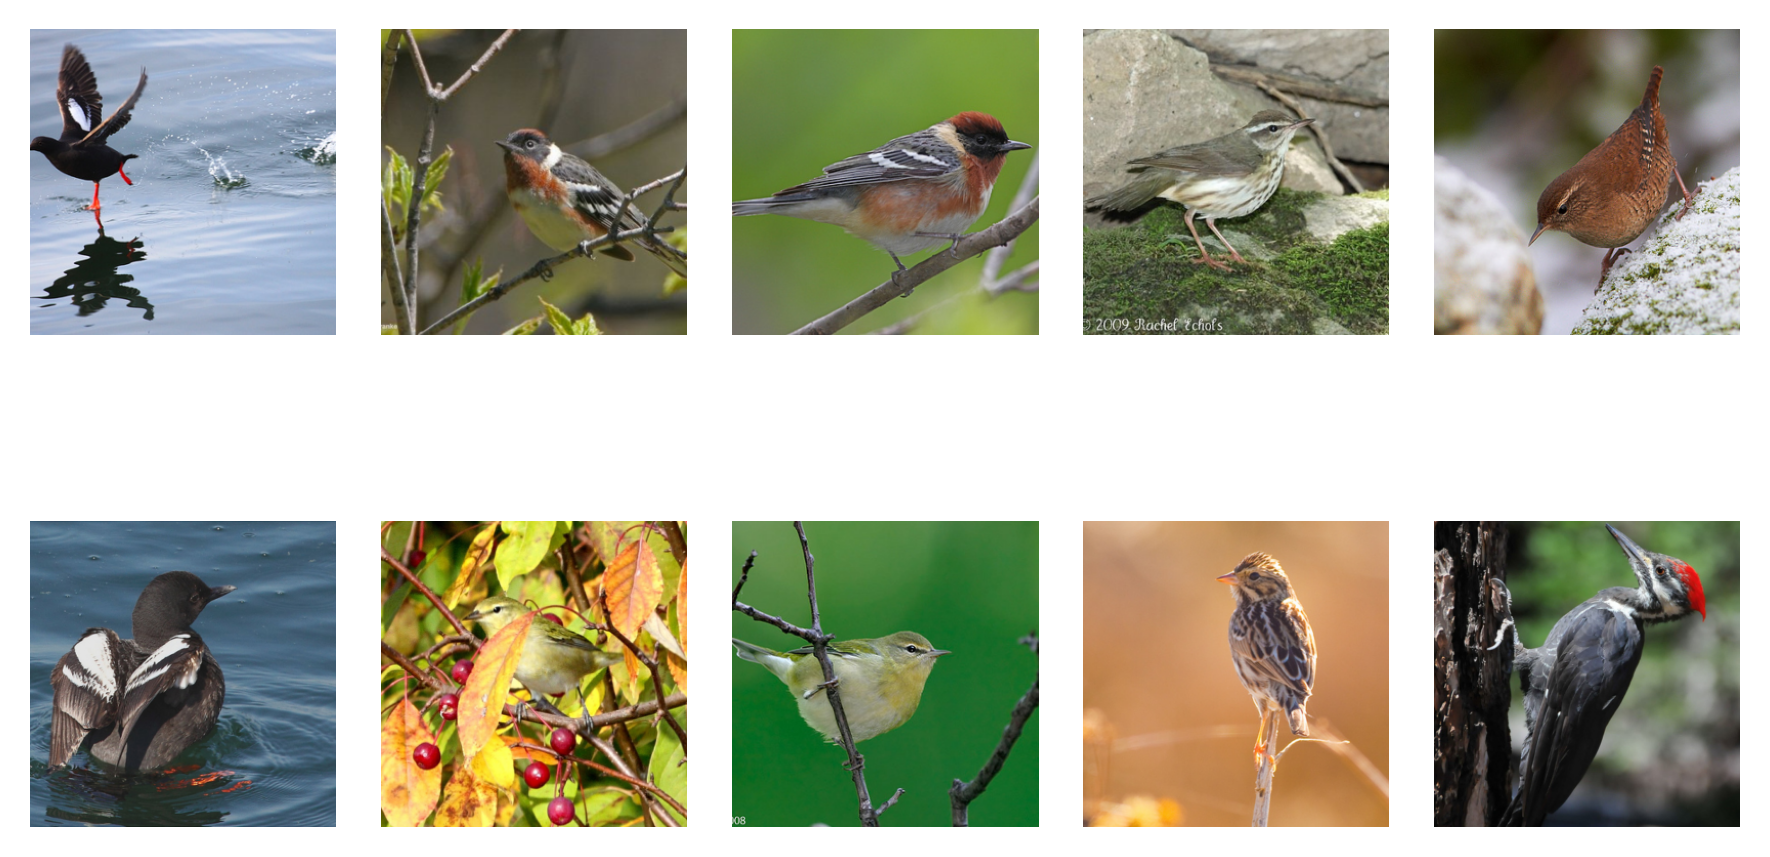

In [116]:
fig, ax = plt.subplots(2,5, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, img in enumerate(imgs):
    input_image = Image.open(img)
    input_tensor = preprocess_visualise(input_image)
    ax[i].imshow(input_tensor.permute(1,2,0))
    ax[i].set_axis_off()

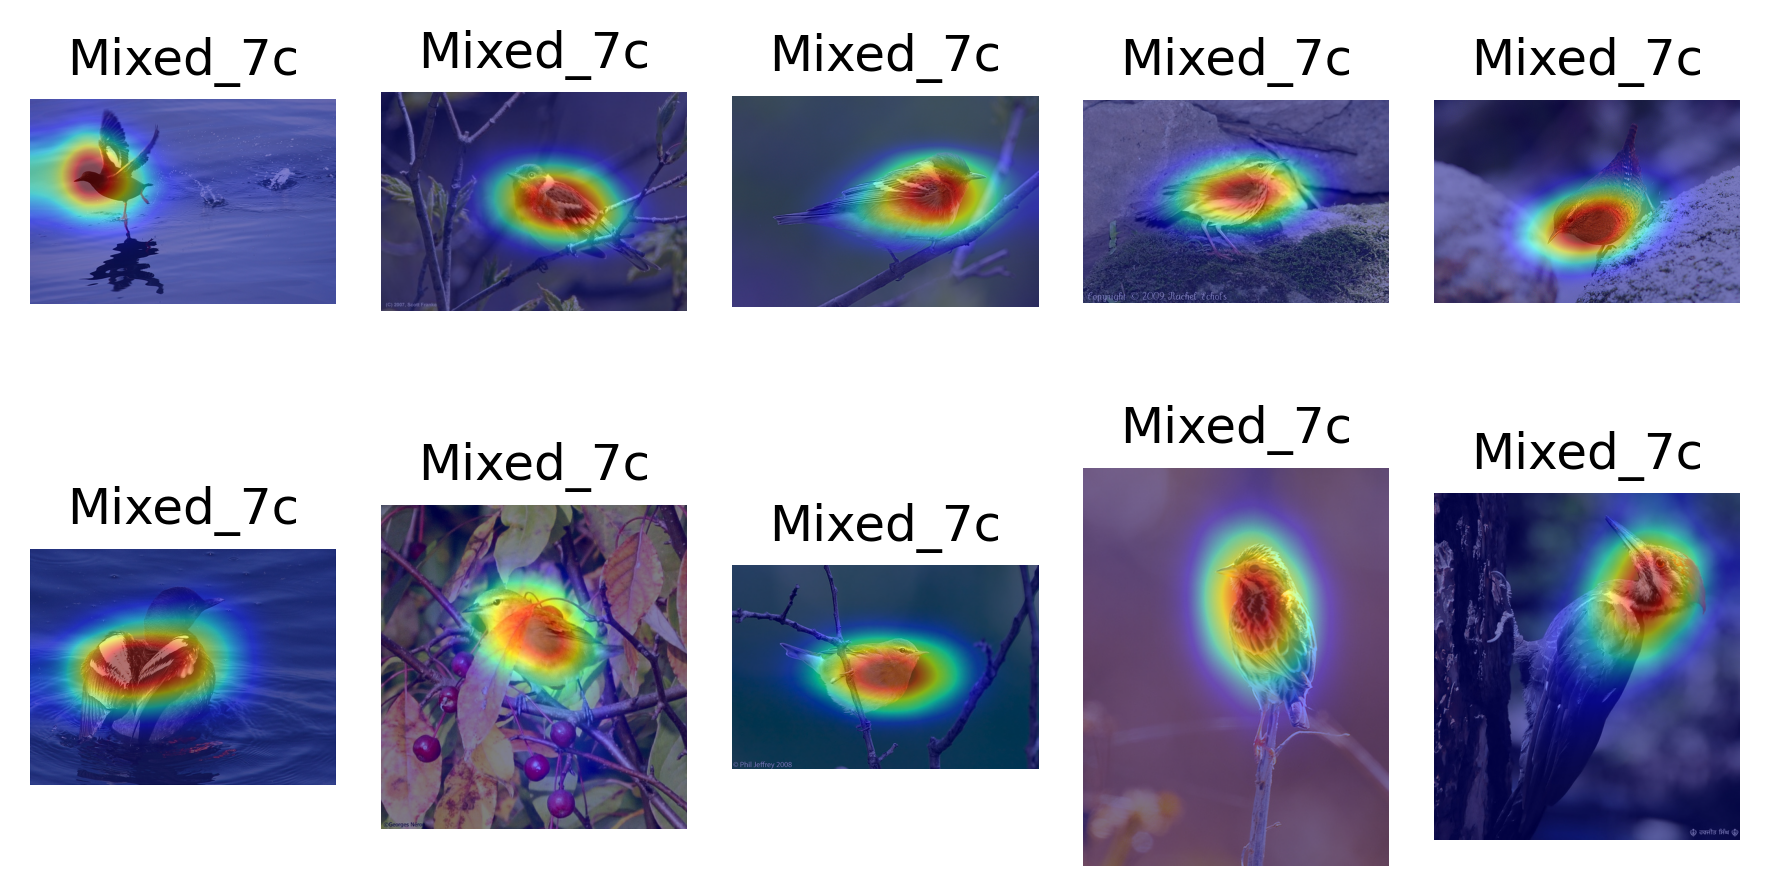

In [134]:
cam_extractor = SmoothGradCAMpp(model)
fig, ax = plt.subplots(2,5, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, img in enumerate(imgs):
    input_image = Image.open(img)
    # img_ = read_image(img)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    out = model(input_batch)
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(input_image, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        ax[i].imshow(result); ax[i].set_axis_off(); ax[i].set_title(name);
cam_extractor.remove_hooks()

## Retrieve the CAM from several layers at the same time


In [56]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["Conv2d_1a_3x3","Mixed_6a", "Mixed_7b", "Mixed_7c"])

# Preprocess your data and feed it to the model
out = model(input_batch)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

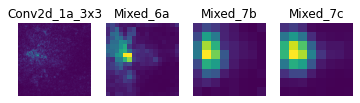

In [57]:
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

Seems pretty evident that we need to use the layers from the latter parts of the model

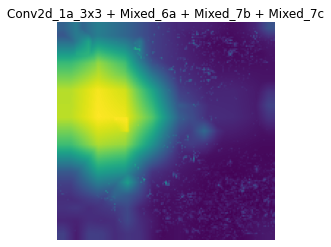

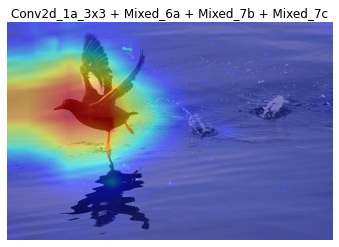

In [58]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [ ]:
cam_extractor.remove_hooks()